# Import Statements

In [172]:
# IMPORT STATEMENTS

#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import ast

# import matplotlib and seaborn to plot charts and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# to split training and testing data
from sklearn.model_selection import train_test_split

# carry out one hot encoding
from feature_engine.encoding import OneHotEncoder

# Import Scalers
# for min-max scaling
from sklearn.preprocessing import MinMaxScaler
# for standardization
from sklearn.preprocessing import StandardScaler
# for robust scaling
from sklearn.preprocessing import RobustScaler

# import XGBRegressor from xgboost package
from xgboost import XGBRegressor

# to evaluate model metrics
from sklearn.metrics import mean_squared_error, r2_score

# import grid search cv to improve decision tree model by helping search for parameters
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session

# to export model
import joblib

# Functions

In [173]:
def model_performance(model):
    print('the training root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_train_scaled), y_train)))
    print('the testing root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_test_scaled), y_test)))

    print()

    #training mse
    train_mse = mean_squared_error(model.predict(X_train_scaled), y_train)
    print('the training mean squared error is: ', train_mse)
    #testing mse
    test_mse = mean_squared_error(model.predict(X_test_scaled), y_test)
    print('the testing mean squared error is: ', test_mse)

    print()

    print('training accuracy is: ', model.score(X_train_scaled, y_train))
    print('testing accuracy is: ', model.score(X_test_scaled, y_test))


# Load Tables From Snowflake

In [174]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [175]:
# retrieve order details usa table from snowflake
order_data_from_snowflake = session.table("frostbyte_tasty_bytes.analytics.ORDER_DETAILS_USA_MATCHED").collect()

In [176]:
# convert order_data_from_snowflake to pandas dataframe
order_df = pd.DataFrame(order_data_from_snowflake)
#order_df = order_data_from_snowflake.to_pandas()

In [177]:
# Get the total quantity sold for each menu item 
## group by 'MENU_ITEM_ID' and calculate the total quantity sold
total_qty_sold_per_item = order_df.groupby('MENU_ITEM_ID')['QUANTITY'].sum().reset_index()

## rename the 'QUANTITY' column to 'TOTAL_QTY_SOLD'
total_qty_sold_per_item = total_qty_sold_per_item.rename(columns={'QUANTITY': 'TOTAL_QTY_SOLD'})

# Menu Table 

In [178]:
# retrieve menu data from snowflake
menu_data_from_snowflake = session.table("frostbyte_tasty_bytes.raw_pos.MENU").collect()

In [179]:
# convert menu_data_from_snowflake to pandas dataframe
menu_df = pd.DataFrame(menu_data_from_snowflake)

In [180]:
# merge total_qty_sold_per_item with final_product_df
menu_df = pd.merge(menu_df, total_qty_sold_per_item, on='MENU_ITEM_ID')

In [181]:
# preview order table
order_df.head()

,ORDER_ID,CUSTOMER_ID,TRUCK_ID,LOCATION_ID,SHIFT_ID,SHIFT_START_TIME,SHIFT_END_TIME,ORDER_CHANNEL,ORDER_TS,SERVED_TS,...,E_MAIL,PHONE_NUMBER,ORDER_DETAIL_ID,MENU_ITEM_ID,DISCOUNT_ID,LINE_NUMBER,QUANTITY,UNIT_PRICE,PRICE,ORDER_ITEM_DISCOUNT_AMOUNT
0,452165023,110872,17,14954.0,200544059,15:00:00,22:00:00,None,2022-07-30 17:34:42,None,...,Jase.Haynes@aol.com,861-138-0409,884494568,21,None,0,3,14.0000,42.0000,None
1,452165023,110872,17,14954.0,200544059,15:00:00,22:00:00,None,2022-07-30 17:34:42,None,...,Jase.Haynes@aol.com,861-138-0409,884494569,23,None,1,1,12.0000,12.0000,None
2,452165023,110872,17,14954.0,200544059,15:00:00,22:00:00,None,2022-07-30 17:34:42,None,...,Jase.Haynes@aol.com,861-138-0409,884494570,27,None,2,1,6.0000,6.0000,None
3,452165023,110872,17,14954.0,200544059,15:00:00,22:00:00,None,2022-07-30 17:34:42,None,...,Jase.Haynes@aol.com,861-138-0409,884494571,28,None,3,1,21.0000,21.0000,None
4,452165023,110872,17,14954.0,200544059,15:00:00,22:00:00,None,2022-07-30 17:34:42,None,...,Jase.Haynes@aol.com,861-138-0409,884494572,29,None,4,1,6.0000,6.0000,None


In [182]:
order_df = order_df.drop(["ORDER_ID", "SHIFT_ID", "SHIFT_START_TIME", "SHIFT_END_TIME", "ORDER_CHANNEL", "ORDER_TS", "SERVED_TS", "E_MAIL", "PHONE_NUMBER", "ORDER_DETAIL_ID", "DISCOUNT_ID", "LINE_NUMBER", "QUANTITY", "UNIT_PRICE", "PRICE", "ORDER_ITEM_DISCOUNT_AMOUNT", "BIRTHDAY_DATE", "SIGN_UP_DATE", "CHILDREN_COUNT", "MARITAL_STATUS", "FAVOURITE_BRAND", "GENDER", "PREFERRED_LANGUAGE", "POSTAL_CODE", "COUNTRY", "FIRST_NAME", "MAX_ORDER_TS", "ORDER_TOTAL", "ORDER_DISCOUNT_AMOUNT", "ORDER_TAX_AMOUNT", "ORDER_AMOUNT", "ORDER_CURRENCY", "LAST_NAME"], axis=1)

order_df.head()

,CUSTOMER_ID,TRUCK_ID,LOCATION_ID,CITY,MENU_ITEM_ID
0,110872,17,14954.0,Denver,21
1,110872,17,14954.0,Denver,23
2,110872,17,14954.0,Denver,27
3,110872,17,14954.0,Denver,28
4,110872,17,14954.0,Denver,29


In [183]:
# Convert 'location_id' column to integers
order_df['LOCATION_ID'] = order_df['LOCATION_ID'].astype(int)

order_df.head()

,CUSTOMER_ID,TRUCK_ID,LOCATION_ID,CITY,MENU_ITEM_ID
0,110872,17,14954,Denver,21
1,110872,17,14954,Denver,23
2,110872,17,14954,Denver,27
3,110872,17,14954,Denver,28
4,110872,17,14954,Denver,29


In [184]:
# preview menu table
menu_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,MENU_ITEM_HEALTH_METRICS_OBJ,TOTAL_QTY_SOLD
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.6500,3.5000,"{\n ""menu_item_health_metrics"": [\n {\n ...",607
1,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.5000,6.0000,"{\n ""menu_item_health_metrics"": [\n {\n ...",1815
2,10003,1,Ice Cream,Freezing Point,12,Waffle Cone,Dessert,Cold Option,2.5000,6.0000,"{\n ""menu_item_health_metrics"": [\n {\n ...",1786
3,10004,1,Ice Cream,Freezing Point,13,Two Scoop Bowl,Dessert,Cold Option,3.0000,7.0000,"{\n ""menu_item_health_metrics"": [\n {\n ...",1682
4,10005,1,Ice Cream,Freezing Point,14,Bottled Water,Beverage,Cold Option,0.5000,2.0000,"{\n ""menu_item_health_metrics"": [\n {\n ...",629


In [185]:
menu_df = menu_df.drop(["MENU_ID", "MENU_TYPE_ID", "MENU_ITEM_NAME", "COST_OF_GOODS_USD", "MENU_ITEM_HEALTH_METRICS_OBJ"]
                        , axis=1)

In [186]:
menu_df.head()

,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,ITEM_CATEGORY,ITEM_SUBCATEGORY,SALE_PRICE_USD,TOTAL_QTY_SOLD
0,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5000,607
1,Ice Cream,Freezing Point,11,Dessert,Cold Option,6.0000,1815
2,Ice Cream,Freezing Point,12,Dessert,Cold Option,6.0000,1786
3,Ice Cream,Freezing Point,13,Dessert,Cold Option,7.0000,1682
4,Ice Cream,Freezing Point,14,Beverage,Cold Option,2.0000,629


# Merge menu table with order table

In [187]:
# merge menu table with order table
merge_df = pd.merge(menu_df, order_df, on='MENU_ITEM_ID')

In [188]:
merge_df.head()

,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,ITEM_CATEGORY,ITEM_SUBCATEGORY,SALE_PRICE_USD,TOTAL_QTY_SOLD,CUSTOMER_ID,TRUCK_ID,LOCATION_ID,CITY
0,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5000,607,73023,61,3227,New York City
1,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5000,607,123976,61,2863,New York City
2,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5000,607,70190,61,10403,New York City
3,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5000,607,14390,61,10408,New York City
4,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5000,607,64073,61,1605,New York City


# Location Table

In [189]:
# retrieve menu data from snowflake
location_data_from_snowflake = session.table("frostbyte_tasty_bytes.raw_pos.LOCATION").collect()

In [190]:
# convert menu_data_from_snowflake to pandas dataframe
location_df = pd.DataFrame(location_data_from_snowflake)

In [191]:
location_df.head()

,LOCATION_ID,PLACEKEY,LOCATION,CITY,REGION,ISO_COUNTRY_CODE,COUNTRY
0,1001,222-222@4hf-nch-k2k,Seasoners Fine Foods,Manchester,Greater Manchester,GB,England
1,1002,222-222@4hf-ndn-4sq,HM Music Promotions,Manchester,Greater Manchester,GB,England
2,1003,222-222@4hf-ndp-grk,G J Hull,Manchester,Greater Manchester,GB,England
3,1004,222-222@4hf-pr3-8qf,Allens Bakery,Manchester,Greater Manchester,GB,England
4,1005,222-222@4hh-ztb-rrk,Just Box,London,Greater London,GB,England


In [192]:
location_df = location_df.drop(["PLACEKEY", "ISO_COUNTRY_CODE", "CITY", "REGION"], axis=1)

location_df.head()

,LOCATION_ID,LOCATION,COUNTRY
0,1001,Seasoners Fine Foods,England
1,1002,HM Music Promotions,England
2,1003,G J Hull,England
3,1004,Allens Bakery,England
4,1005,Just Box,England


# Final Table

In [193]:
# merge table with location table
final_df = pd.merge(merge_df, location_df, on='LOCATION_ID')

In [194]:
final_df.head()

,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,ITEM_CATEGORY,ITEM_SUBCATEGORY,SALE_PRICE_USD,TOTAL_QTY_SOLD,CUSTOMER_ID,TRUCK_ID,LOCATION_ID,CITY,LOCATION,COUNTRY
0,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5000,607,73023,61,3227,New York City,Chinatown Fair Family Fun Center,United States
1,Ice Cream,Freezing Point,11,Dessert,Cold Option,6.0000,1815,73023,61,3227,New York City,Chinatown Fair Family Fun Center,United States
2,Ice Cream,Freezing Point,12,Dessert,Cold Option,6.0000,1786,73023,61,3227,New York City,Chinatown Fair Family Fun Center,United States
3,Ice Cream,Freezing Point,13,Dessert,Cold Option,7.0000,1682,73023,61,3227,New York City,Chinatown Fair Family Fun Center,United States
4,Ice Cream,Freezing Point,14,Beverage,Cold Option,2.0000,629,73023,61,3227,New York City,Chinatown Fair Family Fun Center,United States


In [198]:
# Convert 'sale_price_usd' column to 2 decimal places
final_df['SALE_PRICE_USD'] = final_df['SALE_PRICE_USD'].apply(lambda x: '{:.2f}'.format(x))

final_df.head()

,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,ITEM_CATEGORY,ITEM_SUBCATEGORY,SALE_PRICE_USD,TOTAL_QTY_SOLD,CUSTOMER_ID,TRUCK_ID,LOCATION_ID,CITY,LOCATION,COUNTRY
0,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.50,607,73023,61,3227,New York City,Chinatown Fair Family Fun Center,United States
1,Ice Cream,Freezing Point,11,Dessert,Cold Option,6.00,1815,73023,61,3227,New York City,Chinatown Fair Family Fun Center,United States
2,Ice Cream,Freezing Point,12,Dessert,Cold Option,6.00,1786,73023,61,3227,New York City,Chinatown Fair Family Fun Center,United States
3,Ice Cream,Freezing Point,13,Dessert,Cold Option,7.00,1682,73023,61,3227,New York City,Chinatown Fair Family Fun Center,United States
4,Ice Cream,Freezing Point,14,Beverage,Cold Option,2.00,629,73023,61,3227,New York City,Chinatown Fair Family Fun Center,United States


# Check for Missing Values

In [196]:
final_df.isnull().sum()

MENU_TYPE           0
TRUCK_BRAND_NAME    0
MENU_ITEM_ID        0
ITEM_CATEGORY       0
ITEM_SUBCATEGORY    0
SALE_PRICE_USD      0
TOTAL_QTY_SOLD      0
CUSTOMER_ID         0
TRUCK_ID            0
LOCATION_ID         0
CITY                0
LOCATION            0
COUNTRY             0
dtype: int64

No missing values have been detected. Hence, no process required at this stage.

# Dealing with Outliers

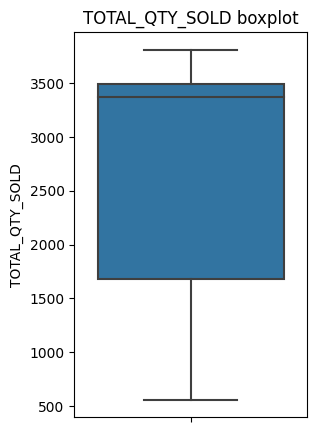

In [199]:
# plot box plot for 'TOTAL_QTY_SOLD' variable
plt.figure(figsize=(3,5))
sns.boxplot(y=final_df['TOTAL_QTY_SOLD'])
plt.title('TOTAL_QTY_SOLD boxplot')
plt.show()

Based on the boxplot shown above, there are no outliers detected. Hence, no process required for this stage.

Note: Outliers for the target variable wold not dealt with even if observed as it would be considered cherry picking convenient data. Furthermore, due to the relatively small number of menu items, if subsetting of the target variable was done, there might be too limited data to build an accurate model.

# Train Test Split

In [201]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop('TOTAL_QTY_SOLD', axis=1), final_df['TOTAL_QTY_SOLD'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((88199, 12), (37800, 12))

# Categorical Variable Encoding 

In [202]:
# let's create the encoder

ohe_enc = OneHotEncoder(
    top_categories=None,
    drop_last=True)  # to return k-1, false to return k

In [203]:
# fit the encoder to the train set: it will learn the variables and 
# categories to encode

ohe_enc.fit(X_train)

OneHotEncoder(drop_last=True)

In [204]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

c:\Users\Darryl koh\.conda\envs\py38_env\lib\site-packages\feature_engine\encoding\one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
c:\Users\Darryl koh\.conda\envs\py38_env\lib\site-packages\feature_engine\encoding\one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
c:\Users\Darryl koh\.conda\envs\py38_env\lib\site-packages\feature_engine\encoding\one_hot.py:277: Performan

# Scaling

## Min Max Scaler

In [205]:
# set up the scaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Standard Scaler

In [ ]:
# # set up the scaler
# scaler = StandardScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Standard Scaler did not lead to a difference in result.

In [ ]:
# # set up the scaler
# scaler = RobustScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Robust Scaler did not lead to a difference in result.

In [ ]:
# let's transform the returned NumPy arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Build Model

In [206]:
# Build XGBoost Model
xgb = XGBRegressor(n_estimators = 20, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb.fit(X_train_scaled, y_train)
model_performance(xgb)

the training root mean squared error is:  341.0011670508962
the testing root mean squared error is:  340.74761183672575

the training mean squared error is:  116281.79593007322
the testing mean squared error is:  116108.93497243192

training accuracy is:  0.9147281732091356
testing accuracy is:  0.9148776659741448


# Improve Model (GridSearch CV)

In [207]:
param_grid = {'n_estimators': [30, 40, 50, 60],
              'learning_rate': [0.1, 0.2, 0.3, 0.4],
              'max_depth': [5,6,7,8]}

xgb_grid = GridSearchCV(xgb, param_grid, cv=5)
xgb_grid.fit(X_train_scaled, y_train)

print("Best parameters found: ", xgb_grid.best_params_)
print("Best score found: ", xgb_grid.best_score_)

# Improved Model Results

In [ ]:
# Build XGBoost Model
xgb_improved = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 50)
# fit the model to the training data
xgb_improved.fit(X_train_scaled, y_train)

model_performance(xgb_improved)

In [ ]:
xgb_improved.feature_importances_